# Style transfer

In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


In [2]:
# Set image width and height
width = 512
height = 512

In [3]:
# Load image

def load_image(path=''):
    assert path != ''
    image = Image.open(path)
    image = image.resize((width, height))
    return image    

# Load content image

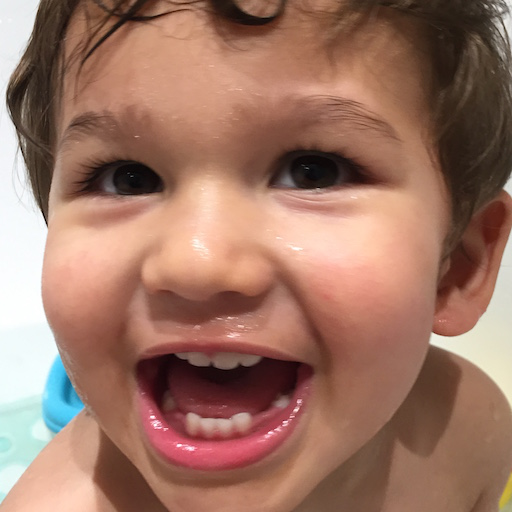

In [4]:
content_image = load_image(path='images/child.png')
content_image

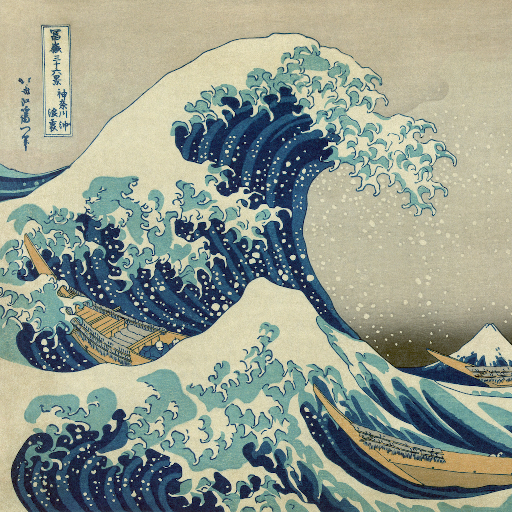

In [5]:
style_image = load_image(path='styles/wave.png')
style_image

# Convert to numerical representation

In [6]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


Before we proceed much further, we need to masage this input data to match what was done in Simonyan and Zisserman (2015), the paper that introduces the VGG Network model that we're going to use shortly.

    * Subtract the mean RGB value (computed previously on the ImageNet training set and easily obtainable from Google searches) from each pixel.
    
    * Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).

In [7]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [8]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, width, height, 3))

In [9]:
# Finally, we concatenate all this image data
# into a single tensor that's suitable for
# processing by Keras' VGG16 model.

input_tensor = backend.concatenate([
    content_image,
    style_image,
    combination_image
], axis=0)

# Use pre-trained vgg-16 model

In [10]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
             include_top=False)

In [11]:
layers = dict([(layer.name, layer.output) for layer in model.layers])

The crux of the paper we're trying to reproduce is that the style transfer problem can be posed as an optimisation problem, where the loss function we want to minimise can be decomposed into three distinct parts: the content loss, the style loss and the total variation loss.

The relative importance of these terms are determined by a set of scalar weights. These are arbitrary, but the following set have been chosen after quite a bit of experimentation to find a set that generates output that's aesthetically pleasing to me.

In [12]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

We'll now use the feature spaces provided by specific layers of our model to define these three loss functions. We begin by initialising the total loss to 0 and adding to it in stages.

In [13]:
loss = backend.variable(0.)

# The content loss

In [14]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]


loss += content_weight * content_loss(
    content_image_features, combination_features
)

# The style loss

For the style loss, we first define something called a Gram matrix. The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. By only capturing these aggregate statistics across the image, they are blind to the specific arrangement of objects inside the image. This is what allows them to capture information about style independent of content.

The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.

In [15]:
def gram_matrix(x):
    features = backend.batch_flatten(
        backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [16]:
# The style loss is then the (scaled, squared)
# Frobenius norm of the difference between the 
# Gram matrices of the style and combination images

def style_loss(style, combination):
    _style = gram_matrix(style)
    _combination = gram_matrix(combination)
    channels = 3
    size = width * height
    _sum = backend.sum(backend.square(_style - _combination))
    return _sum / (4. * (channels ** 2) * (size ** 2))


feature_layers = ['block1_conv2', 'block2_conv2',
    'block3_conv3', 'block4_conv3', 'block5_conv3'
]

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

# Total variation loss

In [17]:
def total_variation_loss(x):
    a = backend.square(
        x[:, :width - 1, :height -1, :] - x[:, 1:, :height - 1, :])
    b = backend.square(
        x[:, :width - 1, :height -1, :] - x[:, :width - 1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

# Define gradients

In [18]:
gradients = backend.gradients(loss, combination_image)

We then introduce an Evaluator class that computes loss and gradients in one pass while retrieving them via two separate functions, loss and grads. This is done because scipy.optimize requires separate functions for loss and gradients, but computing them separately would be inefficient.

In [19]:
outputs = [loss]
outputs += gradients
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_gradients(x):
    x = x.reshape((1, width, height, 3))
    _outputs = f_outputs([x])
    loss_value = _outputs[0]
    gradient_values = _outputs[1].flatten().astype('float64')
    return loss_value, gradient_values

class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.gradient_values = None
        
    def loss(self, x):
        assert self.loss_value is None
        self.loss_value, self.gradient_values = eval_loss_and_gradients(x)
        return self.loss_value
    
    def gradients(self, x):
        assert self.loss_value is not None
        gradient_values = np.copy(self.gradient_values)
        self.loss_value = self.gradient_values = None
        return gradient_values
        
evaluator = Evaluator()

Now we're finally ready to solve our optimisation problem. This combination image begins its life as a random collection of (valid) pixels, and we use the L-BFGS algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon it.

We stop after 10 iterations because the output looks good to me and the loss stops reducing significantly.

In [20]:
def display_image(x):
    _x = x.reshape((width, height, 3))
    _x = _x[:, :, ::-1]
    _x[:, :, 0] += 103.939
    _x[:, :, 1] += 116.779
    _x[:, :, 2] += 123.68
    _x = np.clip(_x, 0, 255).astype('uint8')
    return Image.fromarray(_x)

x = np.random.uniform(0, 255, (1, width, height, 3)) - 128.

epochs = 10

for i in range(epochs):
    print('Start iteration %d' % (i + 1))
    x, min_val, info = fmin_l_bfgs_b(
        evaluator.loss,
        x.flatten(),
        fprime=evaluator.gradients,
        maxfun=20
    )
    print('Current loss value', min_val)
    print('Iteration %d completed' % (i + 1))

Start iteration 1
Current loss value 7.8349e+10
Iteration 1 completed
Start iteration 2
Current loss value 5.10044e+10
Iteration 2 completed
Start iteration 3
Current loss value 4.27022e+10
Iteration 3 completed
Start iteration 4
Current loss value 3.94416e+10
Iteration 4 completed
Start iteration 5
Current loss value 3.78345e+10
Iteration 5 completed
Start iteration 6
Current loss value 3.69338e+10
Iteration 6 completed
Start iteration 7
Current loss value 3.64128e+10
Iteration 7 completed
Start iteration 8
Current loss value 3.60784e+10
Iteration 8 completed
Start iteration 9
Current loss value 3.58617e+10
Iteration 9 completed
Start iteration 10
Current loss value 3.57167e+10
Iteration 10 completed


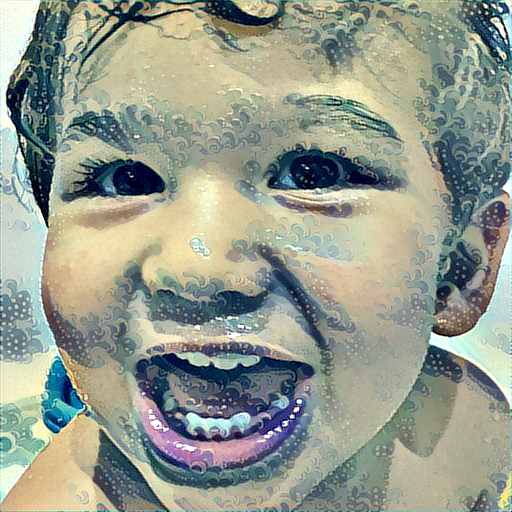

In [21]:
display_image(x)